##### [TenserFlow Core](https://www.tensorflow.org/tutorials?hl=ko)

## 이미지 분류


###### Reference

* [이미지](https://www.tensorflow.org/tutorials/load_data/images?hl=ko)
* [이미지 분류](https://www.tensorflow.org/tutorials/images/classification?hl=ko)

<br />

### 1️⃣ 데이터셋 준비

필요한 라이브러리를 import 합니다.
* numpy
* os
* PIL
* PIL.Image
* tenserflow
* tenserflow_datasets

tenserflow_datasets 모듈이 설치되지 않았다면, `conda install -c anaconda tensorflow-datasets`을 통해 설치한 후 import

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

**꽃 데이터셋**을 로드하고 준비합니다.

flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/

In [2]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname="flower_photos", untar=True)

data_dir = pathlib.Path(data_dir)

다운받은 데이터셋을 확인합니다.

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


각 디렉토리에는 해당 유형의 꽃 이미지가 포함되어 있습니다.

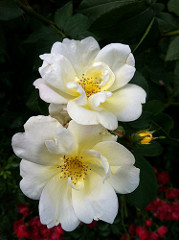

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

<br />

### 2️⃣ 데이터셋 만들기

keras.preprocessing을 사용하여 로드하기

**image_dataset_from_directory**를 사용하여 이들 이미지를 디스크에 로드

In [5]:
batch_size = 32
img_height = 180
img_width = 180

* batch_size : 전체 트레이닝 셋을 여러 작은 그룹으로 나눈 하나의 소그룹에 속하는 데이터 수 (전체 데이터를 신경망에 넣으면 학습시간이 오래 걸려 비효율적일 수 있음)


그리고 모델을 개발하기 전 검증 분할을 사용하는 것이 좋습니다. 앞의 fashion-mnist와 mnist 같은 경우에는 test와 train 데이터셋이 나누어져 있었지만, 지금과 같은 하나의 데이터셋은 분할하여 사용하는 것이 좋습니다.

train 데이터셋은 80%, test 데이터셋은 20%로 분할합니다.

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


데이터셋의 `class_names` 속성에서 클래스 이름을 찾을 수 있습니다.

In [8]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


<br />

### 3️⃣ 데이터 시각화, 표준화하기

##### 시각화

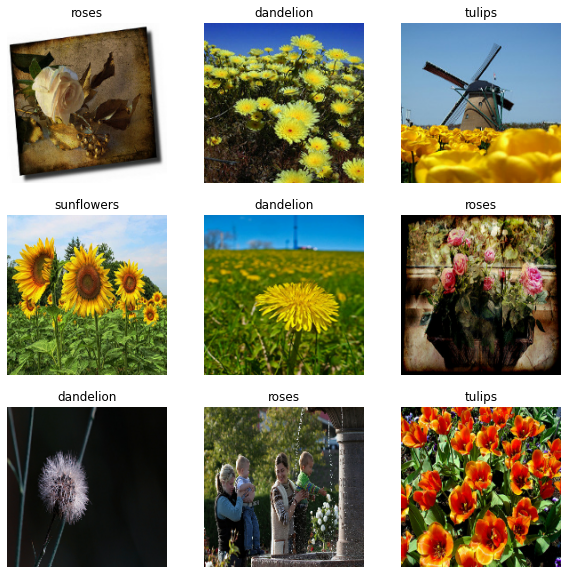

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")

train 데이터셋의 image_batch와 labels_batch 의 텐서를 확인해봅니다.

In [10]:
for image_batch, label_batch in train_ds:
    print(image_batch.shape)
    print(label_batch.shape)
    break

(32, 180, 180, 3)
(32,)


* image_batch는 (32, 180, 180, 3)의 텐서로 180*180*3의 32개 이미지 배치입니다. (여기서 3은 RGB를 의미합니다.)
* label_batch는 (32,)의 텐서로 32개의 이미지에 해당하는 레이블입니다.

<br />

##### 표준화

RGB값은 0 ~ 255 범위이기 때문에, 신경망에 이상적이지 않아서 Rescaling을 통해 값이 (0 ~ 1)사이에 오도록 표준화합니다.

In [11]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

* 참고: 픽셀 값을 (-1,1)으로 조정하려면 대신 `Rescaling(1./127.5, offset=-1)`를 작성할 수 있습니다.

<br />

### 4️⃣ 성능을 위한 데이터셋 구성하기

버퍼링된 프리페치를 사용하여 I/O가 차단되지 않고 디스크에서 데이터를 생성할 수 있도록 합니다.

* .cache() : 첫 번째 epoch동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지합니다. 이렇게 하면 모델을 훈련하는 동안 데이터셋이 병목상태가 되지 않습니다. 데이터셋이 너무 커서 메모리에 맞지 않는 경우, 이 메서드를 사용하여 성능이 높은 온디스크 캐시를 생성할 수 있습니다.
* .prefetch() : 훈련 중에 데이터 전처리 및 모델 실행과 겹칩니다.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

<br />

### 5️⃣ 모델 만들기

모델은 각각에 최대 풀 레이어가 있는 3개의 컨볼루션 레이어로 구성됩니다.


* 컨볼루션 신경망 모델
    * 컨볼루션 레이어 : 영상처리에 주로 사용되는 Conv2D 레이어로 필터로 특징을 뽑아줍니다.
        * `Conv2D(32, (5, 5), padding='same', input_shape=(28, 28, 3), activation='rule')`
            * 첫 번째 인자 : 컨볼루션 필터의 수
            * 두 번째 인자 : (커널의 행, 커널의 열)
            * padding : 경계처리 방법 (valid - 유효한 영역만 출력 / same - 출력 이미지 사이즈가 입력 이미지 사이즈와 동일)
            * input_shape : 샘플 수를 제외한 입력 형태를 정의하는데, **모델에서 첫 레이어일 때만 정의하면 됨**
                * (행, 열, 채널 수)로 정의. 여기서 채널 수는 흑백은 1, 컬러(RGB)는 3
            * activation : 활성화 함수 설정
                * linear : 디폴트
                * relu : rectifer 함수로 은익층에 주로 사용
                * sigmoid : 이진 분류 문제에서 주로 사용
                * softmax : 다중 클래스 분류 문제에서 주로 사용
    * Maxpooling : 데이터의 사이즈를 강제로 줄이기 위한 개념으로, 그 안에서 가장 큰 값을 뽑아내는 방법
        * pooling을 하는 이유 : overfitting을 방지하기 위함

In [13]:
num_classes = 5

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

<br />

### 6️⃣  모델 컴파일 및 훈련하기

In [14]:
model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [16]:
epochs=10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
92/92 [==============================] - 33s 359ms/step - loss: 1.4155 - accuracy: 0.3954 - val_loss: 1.1417 - val_accuracy: 0.5422
Epoch 2/10
92/92 [==============================] - 30s 328ms/step - loss: 1.0520 - accuracy: 0.5851 - val_loss: 0.9487 - val_accuracy: 0.6185
Epoch 3/10
92/92 [==============================] - 31s 336ms/step - loss: 0.8619 - accuracy: 0.6662 - val_loss: 0.9453 - val_accuracy: 0.6158
Epoch 4/10
92/92 [==============================] - 31s 333ms/step - loss: 0.6890 - accuracy: 0.7473 - val_loss: 1.0738 - val_accuracy: 0.5954
Epoch 5/10
92/92 [==============================] - 30s 328ms/step - loss: 0.5069 - accuracy: 0.8243 - val_loss: 1.3210 - val_accuracy: 0.6008
Epoch 6/10
92/92 [==============================] - 30s 328ms/step - loss: 0.3915 - accuracy: 0.8655 - val_loss: 1.2043 - val_accuracy: 0.6362
Epoch 7/10
92/92 [==============================] - 32s 345ms/step - loss: 0.3058 - accuracy: 0.8893 - val_loss: 1.4827 - val_accuracy: 0.5995

<br />

### 7️⃣ 훈련 결과 시각화

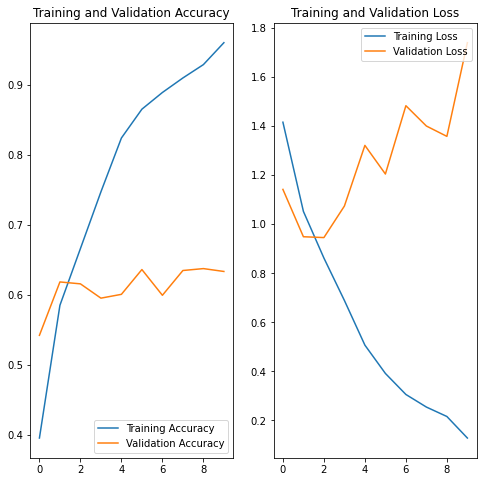

In [17]:
plt.figure(figsize=(8, 8))
# 1. Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(epochs), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(epochs), history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# 2. Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(range(epochs), history.history['loss'], label='Training Loss')
plt.plot(range(epochs), history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

위의 그래프와 같이 훈련 정확성과 검증 정확성에 큰 차이가 있으며, 약 60%의 정확성만 도달하였습니다. 이는 **과대적합**으로 인해 발생하는 것입니다.

###### 과적합 발생 이유
* 데이터가 너무 적을 경우
* 데이터 전처리를 잘못했을 경우
* Feature 데이터가 너무 많을 경우
    
###### 과적합 줄이는 방법
* 데이터 증강
* 특징을 줄이거나(드랍아웃) 정규화하기

<br />

### 8️⃣ 과적합 방지

##### 데이터 증강

일반적으로 과적합은 훈련 예제가 적을 때 발생합니다. **데이터 증강**은 증강한 다음 믿을 수 있는 이미지를 생성하는 임의 변환을 사용하는 방법.

In [18]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)])

동일한 이미지에 데이터 증강을 여러 번 적용하여 어떻게 증강이 되는지 시각화해보기

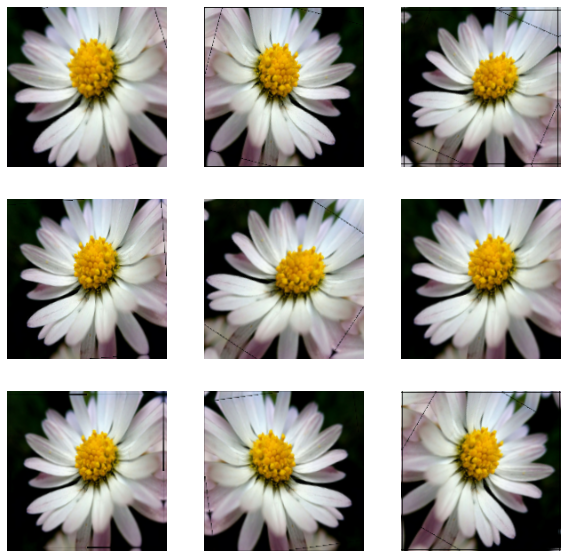

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

<br />

##### 드롭아웃

과적합을 줄이는 또 다른 기술은 정규화의 한 형태인 **드롭아웃**을 도입하는 것입니다. 드롭아웃을 적용하면, 훈련 프로세스 중에 레이어에서 여러 출력 단위가 무작위로 드롭아웃됩니다. 드롭아웃은 0.1, 0.2, 0.4 등의 형식으로 소수를 입력 값으로 사용합니다.

이는 적용된 레이어에서 출력 단위의 10%, 20% 또는 40%를 임의로 제거하는 것을 의미합니다.

**데이터 증강, 드롭아웃을 적용한 모델을 새롭게 만들어 훈련해봅니다.**

In [20]:
model = tf.keras.Sequential([
  data_augmentation,      # 증강한 데이터셋
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),    # 드롭아웃
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

<br />

### 9️⃣ 모델 컴파일 및 훈련하기

In [21]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

이제, 이 모델을 훈련합니다.

In [23]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 36s 393ms/step - loss: 1.3545 - accuracy: 0.4101 - val_loss: 1.1194 - val_accuracy: 0.5395
Epoch 2/15
92/92 [==============================] - 36s 391ms/step - loss: 1.0573 - accuracy: 0.5811 - val_loss: 1.0324 - val_accuracy: 0.5763
Epoch 3/15
92/92 [==============================] - 35s 383ms/step - loss: 0.9529 - accuracy: 0.6178 - val_loss: 1.0172 - val_accuracy: 0.5940
Epoch 4/15
92/92 [==============================] - 35s 381ms/step - loss: 0.8841 - accuracy: 0.6529 - val_loss: 1.0053 - val_accuracy: 0.6035
Epoch 5/15
92/92 [==============================] - 35s 381ms/step - loss: 0.8323 - accuracy: 0.6795 - val_loss: 1.0040 - val_accuracy: 0.6294
Epoch 6/15
92/92 [==============================] - 35s 379ms/step - loss: 0.7734 - accuracy: 0.7067 - val_loss: 0.8144 - val_accuracy: 0.6730
Epoch 7/15
92/92 [==============================] - 35s 382ms/step - loss: 0.7250 - accuracy: 0.7159 - val_loss: 0.8934 - val_accuracy: 0.6512

<br />

### 🔟 훈련 결과 시각화하기

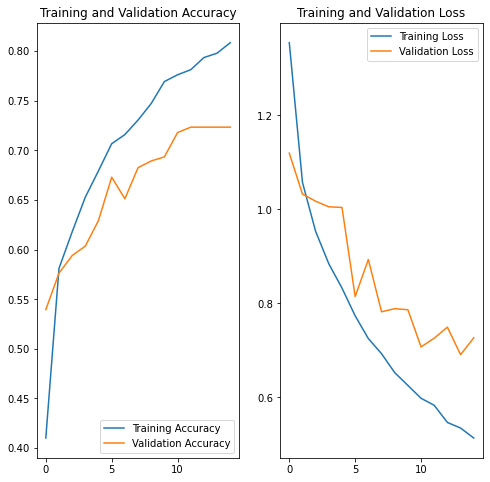

In [24]:
plt.figure(figsize=(8, 8))
# 1. Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(epochs), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(epochs), history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# 2. Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(range(epochs), history.history['loss'], label='Training Loss')
plt.plot(range(epochs), history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()